---
### KBO 타자 OPS 예측 경진대회
- https://dacon.io/competitions/official/62540/overview/description
- goal : 2019년 타자들의 상반기 OPS를 예측하는 모델 개발
- 평가지표 : WRMSE (타수가 많은, 즉 주전선수들의 기록에 더 많은 가중치를 부여함)
- data 
  1. Regular_Season_Batter.csv : KBO에서 활약한 타자들의 역대 정규시즌 성적을 포함하여 몸무게, 키 ,생년월일 등의 기본정보 
  2. Regular_Season_Batter_Day_by_Day.csv: KBO에서 활약한 타자들의 일자 별 정규시즌 성적 
  3. Pre_Season_Batter.csv : KBO에서 활약한 타자들의 역대 시범경기(정규시즌 직전에 여는 연습경기) 성적 
  4. submission.csv : 참가자들이 예측해야 할 타자의 이름과 아이디 목록
---

#### ※참고. 주요 야구 용어 
1. OPS : On-base Plus Slugging, 출루율(OBP) + 장타율(SLG)
2. OBP : 출루율, 타수대비 1루 출루 비율 
3. SLG : 장타율, 타수대비 평균 루타 
4. AB : 타수, 타자가 정규 타격완료 횟수 
5. BB : 볼넷 
6. HBP : 사구 
7. SF : 희생플라이 
8. AVG : 타율 
9. 1B,2B,3B : 1~3루타 
10. HR, H : 홈런, 안타 

---
##### 1. EDA 
---

In [96]:
import numpy as np 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc 
import seaborn as sns
import koreanize_matplotlib
import warnings 
warnings.filterwarnings('ignore')

#차트 폰트 및 마이너스 표시 설정 
mpl.rc('font', size=9)
mpl.rcParams['axes.unicode_minus'] = False
pd.set_option('display.max_columns', None)  # 모든 열 출력

In [97]:
# data loading
preseason_df = pd.read_csv('KBO_data\Pre_Season_Batter.csv')
regular_season_df = pd.read_csv('KBO_data\Regular_Season_Batter.csv')

print('프리시즌 데이터 크기 = ', preseason_df.shape)
print('정규시즌 데이터 크기 = ', regular_season_df.shape)

프리시즌 데이터 크기 =  (1393, 29)
정규시즌 데이터 크기 =  (2454, 29)


In [98]:
preseason_df.head()

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS
0,0,가르시아,2018,LG,0.350,7,20,1,7,1,0,1,11,5,0,0,2,0,3,1,0.550,0.409,1,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.959
1,1,강경학,2011,한화,0.000,4,2,2,0,0,0,0,0,1,0,1,0,2,1,0,0.000,0.500,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.500
2,1,강경학,2014,한화,-,4,0,2,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,NaN
3,1,강경학,2015,한화,0.130,10,23,3,3,0,0,0,3,1,3,0,4,1,9,0,0.130,0.286,2,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.416
4,1,강경학,2016,한화,0.188,14,32,4,6,1,1,0,9,2,1,2,0,1,10,0,0.281,0.212,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.493


In [99]:
# 기술통계량 
preseason_df.describe().T

,count,mean,std,min,25%,50%,75%,max
batter_id,1393.0,173.434314,94.716851,0.0,99.000,178.0000,254.000,344.0
year,1393.0,2013.014358,4.166757,2002.0,2010.000,2014.0000,2017.000,2018.0
G,1393.0,8.705671,5.562686,1.0,6.000,9.0000,11.000,119.0
AB,1393.0,19.201723,13.395946,0.0,9.000,18.0000,28.000,183.0
R,1393.0,2.679828,2.637212,0.0,1.000,2.0000,4.000,35.0
H,1393.0,5.021536,4.232584,0.0,2.000,4.0000,8.000,51.0
2B,1393.0,0.954774,1.196904,0.0,0.000,1.0000,2.000,11.0
3B,1393.0,0.119885,0.379976,0.0,0.000,0.0000,0.000,4.0
HR,1393.0,0.391960,0.748557,0.0,0.000,0.0000,1.000,5.0
TB,1393.0,7.391960,6.538787,0.0,2.000,6.0000,11.000,68.0


array([[<Axes: title={'center': 'batter_id'}>,
        <Axes: title={'center': 'year'}>, <Axes: title={'center': 'G'}>,
        <Axes: title={'center': 'AB'}>, <Axes: title={'center': 'R'}>],
       [<Axes: title={'center': 'H'}>, <Axes: title={'center': '2B'}>,
        <Axes: title={'center': '3B'}>, <Axes: title={'center': 'HR'}>,
        <Axes: title={'center': 'TB'}>],
       [<Axes: title={'center': 'RBI'}>, <Axes: title={'center': 'SB'}>,
        <Axes: title={'center': 'CS'}>, <Axes: title={'center': 'BB'}>,
        <Axes: title={'center': 'HBP'}>],
       [<Axes: title={'center': 'SO'}>, <Axes: title={'center': 'GDP'}>,
        <Axes: title={'center': 'SLG'}>, <Axes: title={'center': 'OBP'}>,
        <Axes: title={'center': 'E'}>],
       [<Axes: title={'center': 'OPS'}>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

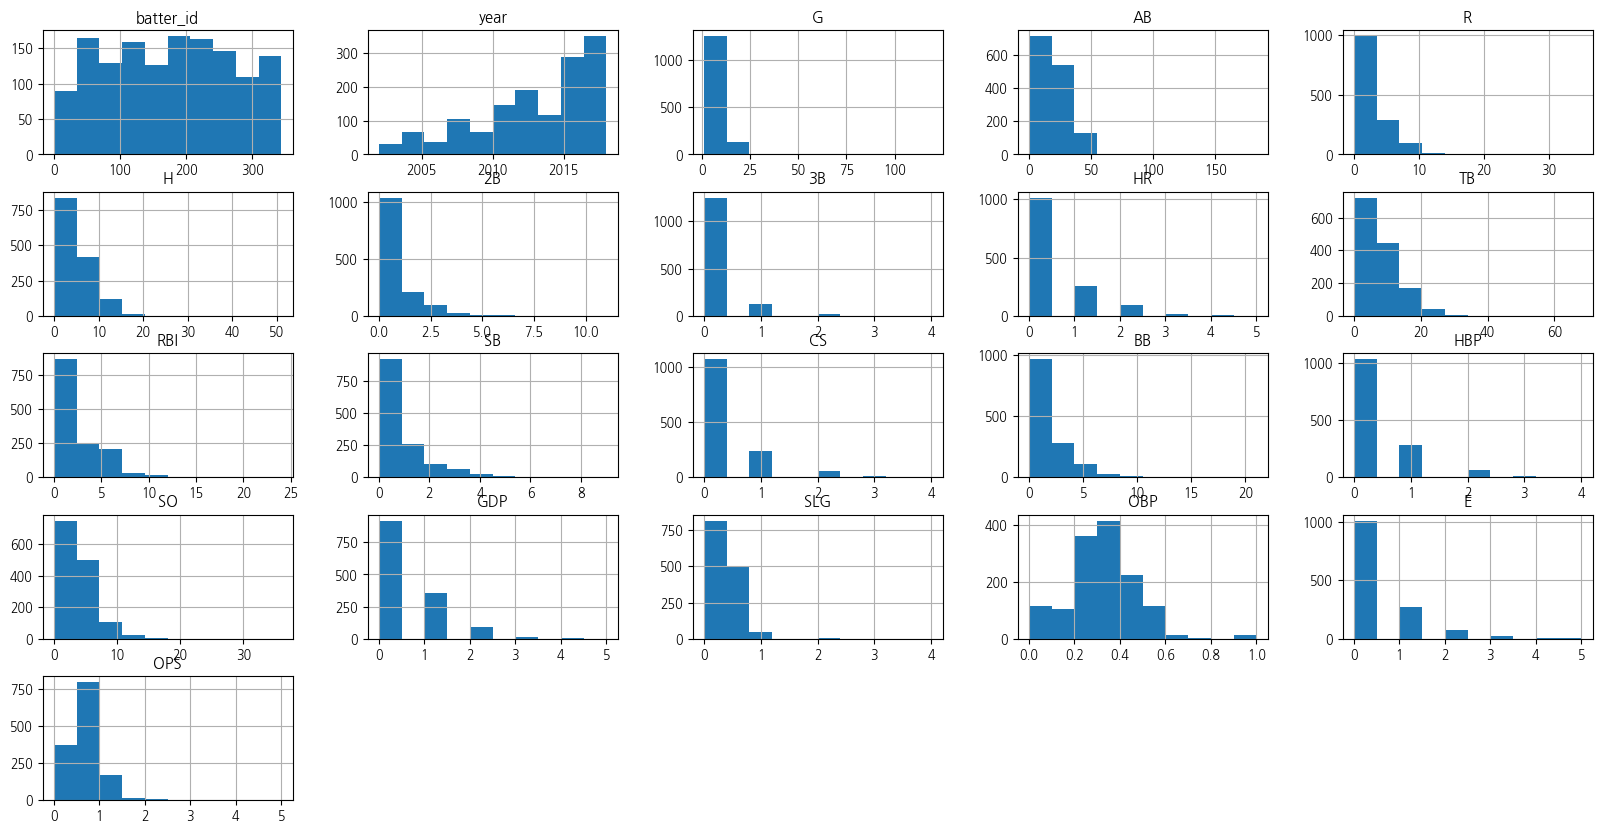

In [100]:
# 수치형 데이터 히스토그램 
preseason_df.hist(figsize=(20,10))

In [101]:
# 연도별 프리/정규 시즌 타자 수 확인 및 비교 
preseason_cnt = preseason_df.groupby('year')['batter_id'].count().rename('preseason')
regular_season_cnt = regular_season_df.groupby('year')['batter_id'].count().rename('regular_season')

pd.concat([preseason_cnt, regular_season_cnt, np.round(preseason_cnt/regular_season_cnt, 2).rename('ratio')], axis=1).sort_index()

,preseason,regular_season,ratio
year,,,
1993,NaN,1,NaN
1994,NaN,2,NaN
1995,NaN,1,NaN
1996,NaN,7,NaN
1997,NaN,8,NaN
1998,NaN,10,NaN
1999,NaN,14,NaN
2000,NaN,20,NaN
2001,NaN,32,NaN


In [102]:
# 프리시즌 성적과 정규시즌 성적의 상관관계 살펴보기 
## 선수이름+연도가 일치하는 데이터만 추출 

preseason_df['new_idx'] = preseason_df['batter_name'] + preseason_df['year'].apply(str)
regular_season_df['new_idx'] = regular_season_df['batter_name'] + regular_season_df['year'].apply(str)

## 교집합 구하기 (set함수는 df를 집합형태로 변경하여 연산함)
intersection_idx = list(set.intersection(set(regular_season_df['new_idx']), set(preseason_df['new_idx'])))
print('교집합: ', len(intersection_idx), intersection_idx[:10])

## 프리/정규시즌 데이터 중에서 교집합에 포함된 건들만 추출 
preseason_new = preseason_df.loc[preseason_df['new_idx'].apply(lambda x: x in intersection_idx)].copy()
preseason_new = preseason_new.sort_values(by='new_idx').reset_index(drop=True)

regular_season_new = regular_season_df.loc[regular_season_df['new_idx'].apply(lambda x: x in intersection_idx)].copy()
regular_season_new = regular_season_new.sort_values(by='new_idx').reset_index(drop=True)

print('추출된 데이터: ', preseason_new.shape, regular_season_new.shape)
regular_season_new.head()

교집합:  1358 ['임훈2004', '최승준2015', '나주환2015', '김동욱2016', '나주환2017', '이동훈2017', '김상호2017', '김주형2008', '박헌도2015', '이범호2015']
추출된 데이터:  (1358, 30) (1358, 30)


,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS,new_idx
0,0,가르시아,2018,LG,0.339,50,183,27,62,9,0,8,95,34,5,0,9,8,25,3,0.519,0.383,9,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.902,가르시아2018
1,1,강경학,2011,한화,0.000,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000,0.000,1,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.000,강경학2011
2,1,강경학,2014,한화,0.221,41,86,11,19,2,3,1,30,7,0,0,13,2,28,1,0.349,0.337,6,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.686,강경학2014
3,1,강경학,2015,한화,0.257,120,311,50,80,7,4,2,101,27,4,3,40,5,58,3,0.325,0.348,15,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.673,강경학2015
4,1,강경학,2016,한화,0.158,46,101,16,16,3,2,1,26,7,0,0,8,2,30,5,0.257,0.232,7,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.489,강경학2016


#### ※ 참고. 교집합, 합집합 구하기 ~ set.intersection(data1, data2), set.union(data1, data2)
- 단 여기서 data의 형태는 집합이어야 하므로, set.intersection(set(data1), set(data2))와 같이 사용된다. 

corr =  0.14872584643104408


Text(0, 0.5, '정규시즌 OPS')

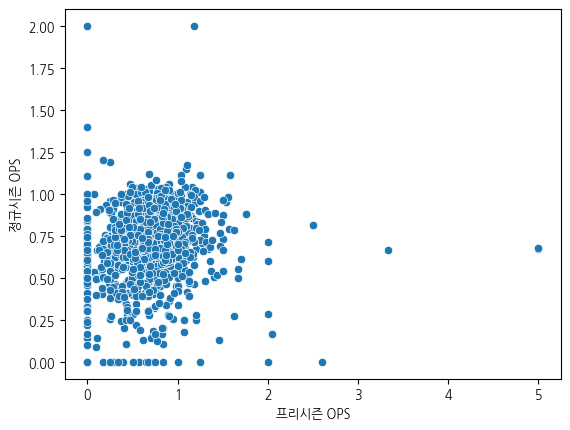

In [103]:
# 프리-정규시즌 성적의 상관관계 
correlation = preseason_new['OPS'].corr(regular_season_new['OPS'])
print('corr = ', correlation)

sns.scatterplot(x=preseason_new['OPS'], y=regular_season_new['OPS'])
plt.xlabel('프리시즌 OPS')
plt.ylabel('정규시즌 OPS')

- 결론: 프리시즌 데이터는 2002년 이전 것은 없으며, 예측 목표인 정규시즌 성적과 큰 연관성이 없으므로, 분석대상에서 제외하는 것이 좋겠다. 

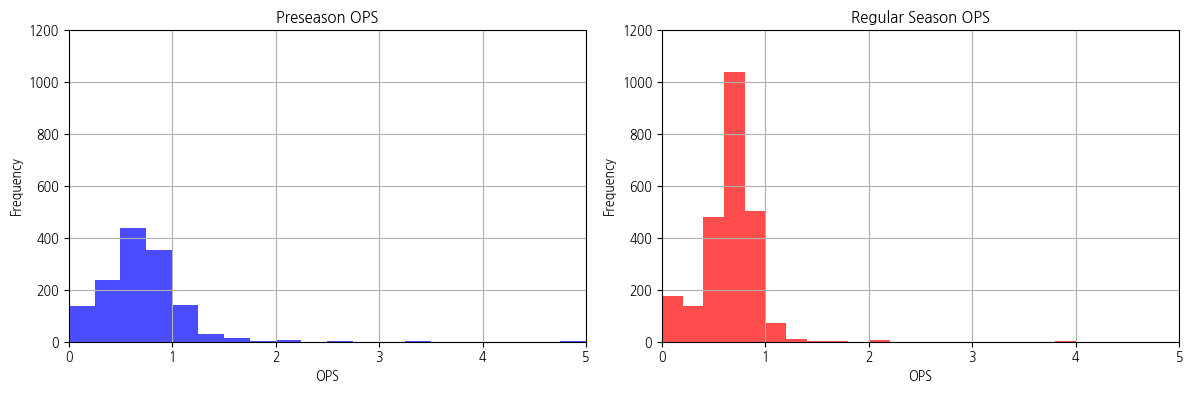

In [104]:
# 목표변수- OPS의 특징 파악 
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

preseason_df['OPS'].hist(ax=axes[0], bins=20, color='blue', alpha=0.7)
axes[0].set_title('Preseason OPS')
axes[0].set_xlabel('OPS')
axes[0].set_ylabel('Frequency')

regular_season_df['OPS'].hist(ax=axes[1], bins=20, color='red', alpha=0.7)
axes[1].set_title('Regular Season OPS')
axes[1].set_xlabel('OPS')
axes[1].set_ylabel('Frequency')

# x축과 y축 범위를 동일하게 설정
axes[0].set_xlim(0,5)
axes[1].set_xlim(0,5)
axes[0].set_ylim(0, 1200)
axes[1].set_ylim(0, 1200)

plt.tight_layout()


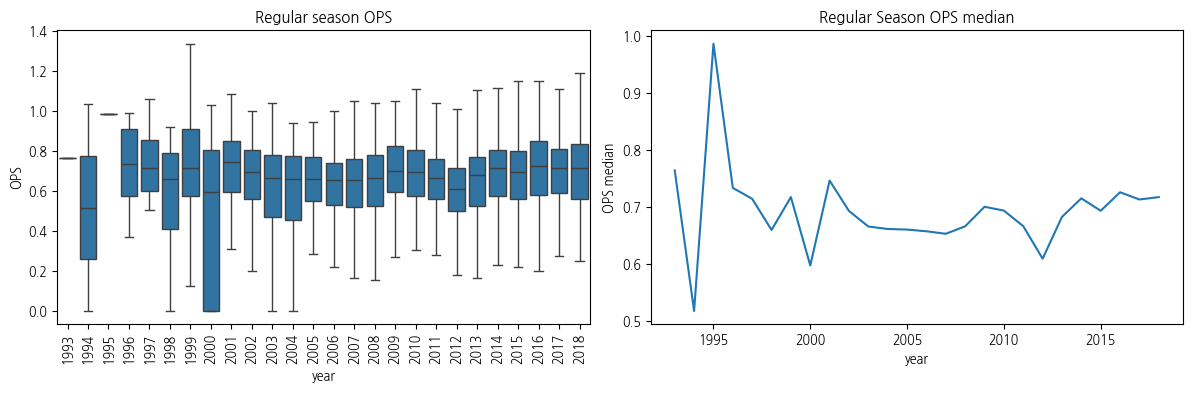

In [129]:
# regular season OPS 상세 
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.boxplot(data=regular_season_df, x='year', y='OPS', ax=axes[0], showfliers=False)
axes[0].set_title('Regular season OPS')
axes[0].set_xlabel('year')
axes[0].set_ylabel('OPS')
axes[0].tick_params(axis='x', rotation=90)

plt.plot(regular_season_df.groupby('year')['OPS'].median())
axes[1].set_title('Regular Season OPS median')
axes[1].set_xlabel('year')
axes[1].set_ylabel('OPS median')

plt.tight_layout()


In [106]:
pd.crosstab(regular_season_df['year'], 'count').T

year,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
col_0,,,,,,,,,,,,,,,,,,,,,,,,,,
count,1,2,1,7,8,10,14,20,32,43,54,68,73,85,98,115,124,130,151,174,194,186,207,213,217,227


- 과거(대략 2000년 이전) 기록된 데이터가 적어, 예전 데이터의 변동폭이 매우 크다. 

Text(0.5, 1.0, 'OPS of teams')

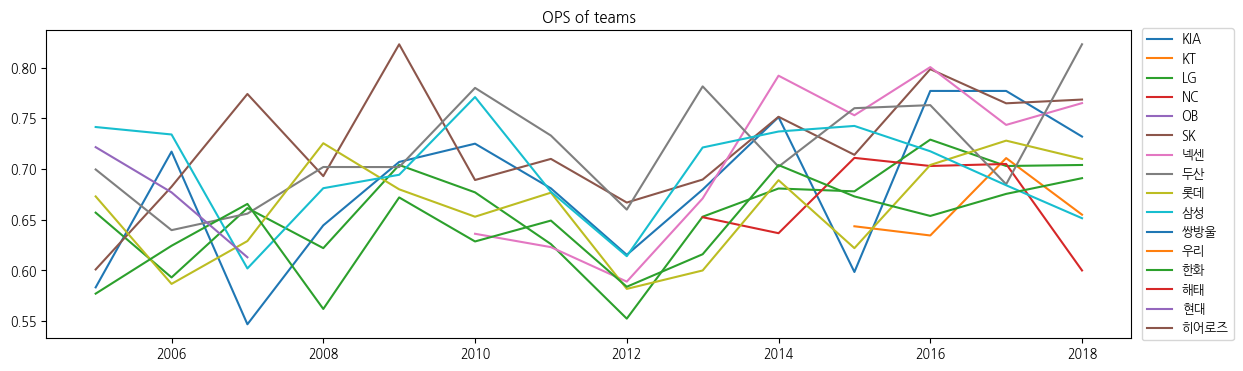

In [107]:
# 팀별 ops의 중앙값 확인 
med_ops_team = regular_season_df.pivot_table(index='team', columns = 'year', values='OPS', aggfunc='median')

## 사라진 팀도 있으므로, 2005년 이후 결측치가 없는 팀만 
team_idx = med_ops_team.loc[:, 2005:].isna().sum(axis=1) <= 0 

plt.figure(figsize=(14,4))
plt.plot(med_ops_team.loc[:, 2005:].T)
plt.legend(med_ops_team.loc[:, 2005:].T.columns, loc='center right', bbox_to_anchor=(1.1, 0.5))
plt.title('OPS of teams')

- 선수의 소속팀은 OPS에 유효한 영향을 미치고 있는 것 같다. 

In [108]:
# 신장, 체중과 OPS의 연관성 파악 
## re.findall('\d+', ~~) : 정규표현식을 사용하여 숫자를 추출합니다. '\d+'는 연속된 숫자를 의미
import re 

## 컬럼 height/weight(177cm/93kg 형태)로 부터 값 추출  
regular_season_df['weight'] = regular_season_df['height/weight'].apply(lambda x: int(re.findall('\d+', x.split('/')[1])[0]) if pd.notnull(x) else (x) ) 
regular_season_df['height'] = regular_season_df['height/weight'].apply(lambda x: int(re.findall('\d+', x.split('/')[0])[0]) if pd.notnull(x) else (x) )
print(regular_season_df['weight'][0], regular_season_df['height'][0])

# 몸무게를 키로 나눈 새로운 변수 생성 
regular_season_df['weight_per_height'] = regular_season_df['weight'] / regular_season_df['height'] 
print(regular_season_df['weight_per_height'][0])

93.0 177.0
0.5254237288135594


correlation : Height & OPS 0.0997
correlation : Height & OPS 0.0997


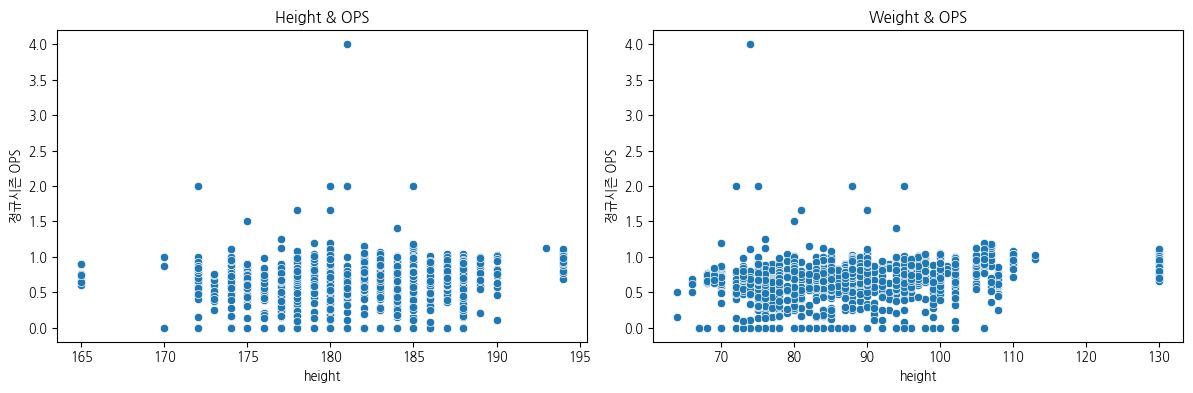

In [109]:
## correlation and 시각화 ~ 키/몸무게와 OPS
corr_H = regular_season_df['height'].corr(regular_season_df['OPS'])
corr_W = regular_season_df['weight'].corr(regular_season_df['OPS'])
print('correlation : Height & OPS', round(corr_H, 4))
print('correlation : Height & OPS', round(corr_H, 4))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.scatterplot(data=regular_season_df, x='height', y='OPS', ax=axes[0])
axes[0].set_title('Height & OPS')
axes[0].set_xlabel('height')
axes[0].set_ylabel('정규시즌 OPS')

sns.scatterplot(data=regular_season_df, x='weight', y='OPS', ax=axes[1])
axes[1].set_title('Weight & OPS')
axes[1].set_xlabel('height')
axes[1].set_ylabel('정규시즌 OPS')

plt.tight_layout()
plt.show()

correlation : Weight/Height & OBP 0.2013
correlation : Weight/Height & OBP 0.1293
correlation : Weight/Height & SLG 0.2292


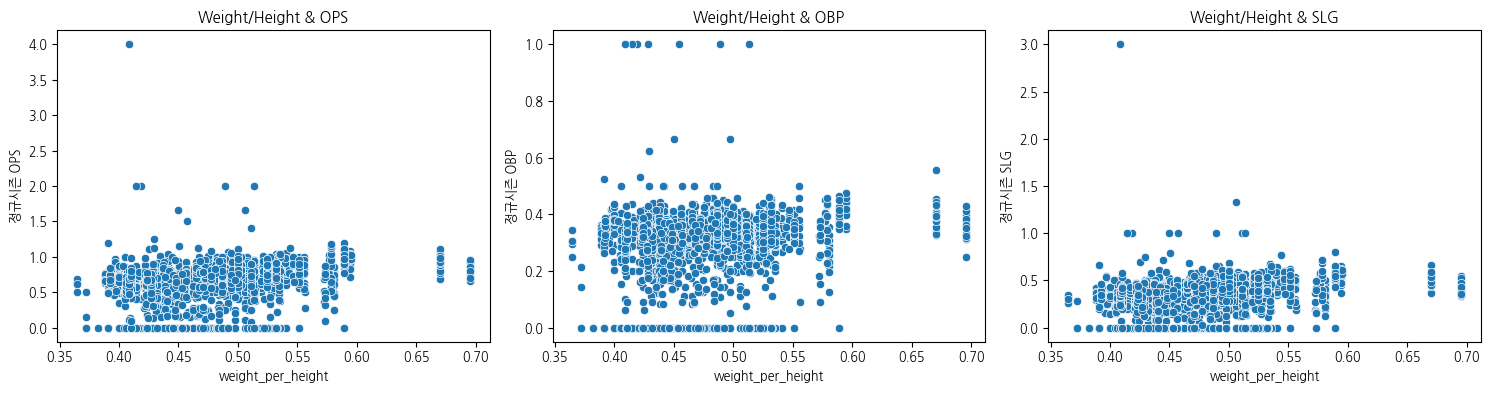

In [110]:
# 단순 키, 몸무게가 아닌 weight_per_height를 사용해 본다. 
## correlation and 시각화 ~ 키/몸무게와 OPS, 출루율, 장타율 
corr0 = regular_season_df['weight_per_height'].corr(regular_season_df['OPS'])
corr1 = regular_season_df['weight_per_height'].corr(regular_season_df['OBP'])
corr2 = regular_season_df['weight_per_height'].corr(regular_season_df['SLG'])

print('correlation : Weight/Height & OBP', round(corr0, 4))
print('correlation : Weight/Height & OBP', round(corr1, 4))
print('correlation : Weight/Height & SLG', round(corr2, 4))

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.scatterplot(data=regular_season_df, x='weight_per_height', y='OPS', ax=axes[0])
axes[0].set_title('Weight/Height & OPS')
axes[0].set_xlabel('weight_per_height')
axes[0].set_ylabel('정규시즌 OPS')

sns.scatterplot(data=regular_season_df, x='weight_per_height', y='OBP', ax=axes[1])
axes[1].set_title('Weight/Height & OBP')
axes[1].set_xlabel('weight_per_height')
axes[1].set_ylabel('정규시즌 OBP')

sns.scatterplot(data=regular_season_df, x='weight_per_height', y='SLG', ax=axes[2])
axes[2].set_title('Weight/Height & SLG')
axes[2].set_xlabel('weight_per_height')
axes[2].set_ylabel('정규시즌 SLG')

plt.tight_layout()
plt.show()

- 키, 몸무게는 OPS 및 출루율&장타율과 별다른 관계성을 보이지 않는다. 

In [111]:
# 포지션과의 연관성 확인 
## position컬럼은 "내야수(우투우타)"와 같은 형태이므로, 먼저 텍스트를 분리해야 함
regular_season_df['수비위치'] = regular_season_df['position'].apply(lambda x: x.split('(')[0] if pd.notnull(x) else x) 
regular_season_df['타격_손'] = regular_season_df['position'].apply(lambda x: x[-3:-1] if pd.notnull(x) else x) 

print(regular_season_df['수비위치'][0], regular_season_df['타격_손'][0])

내야수 우타


수비위치별 OPS 중앙값 =  수비위치
내야수    0.706
외야수    0.719
포수     0.639
Name: OPS, dtype: float64
타격_손별 OPS 중앙값 =  타격_손
양타    0.630
우타    0.700
좌타    0.713
Name: OPS, dtype: float64


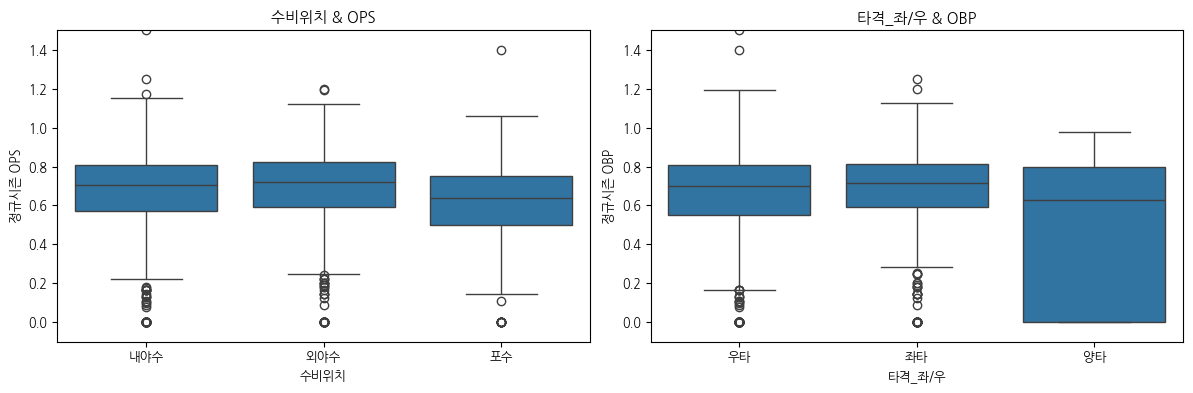

In [112]:
med_position = regular_season_df.groupby('수비위치')['OPS'].median()
med_hand = regular_season_df.groupby('타격_손')['OPS'].median()
print('수비위치별 OPS 중앙값 = ', med_position)
print('타격_손별 OPS 중앙값 = ', med_hand)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.boxplot(data=regular_season_df, x='수비위치', y='OPS', ax=axes[0])
axes[0].set_title('수비위치 & OPS')
axes[0].set_xlabel('수비위치')
axes[0].set_ylabel('정규시즌 OPS')
axes[0].set_ylim(-0.1, 1.5)

sns.boxplot(data=regular_season_df, x='타격_손', y='OPS', ax=axes[1])
axes[1].set_title('타격_좌/우 & OBP')
axes[1].set_xlabel('타격_좌/우')
axes[1].set_ylabel('정규시즌 OBP')
axes[1].set_ylim(-0.1, 1.5)

plt.tight_layout()
plt.show()

In [113]:
## n이 충분한지 확인 
temp1 = regular_season_df['수비위치'].value_counts()
temp2 = regular_season_df['타격_손'].value_counts()
print(temp1, temp2)

수비위치
내야수    827
외야수    622
포수     203
Name: count, dtype: int64 타격_손
우타    1062
좌타     576
양타      14
Name: count, dtype: int64


- 내야수/외야수의 차이는 거의 없으나, 포수의 OPS는 상대적으로 다소 낮다. 
- 양손타자의 사례수가 너무 적어서 의미를 부여하기 어렵다. 타격_손(좌/우타)이 OPS에 미치는 영향은 거의 없음 

In [114]:
# 커리어와 OPS : 외국인 선수들은 표기방식이 한국선수와 다름 유의하여, 새로운 변수 country 생성 

## '-'와 공백 제거 
foreign_country = regular_season_df['career'].apply(lambda x: x.replace('-', ' ').split(' ')[0])
print(foreign_country[:5])

## 외국인 추출 ~ 처음에 초등학교가 표시되면 한국선수이므로 NaN 처리 & 리스트 변환 
foreign_country_list = list(set(foreign_country.apply(lambda x: np.nan if '초' in x else x)))
print(foreign_country_list) 

## 결측치 제거 
foreign_country_list = [x for x in foreign_country_list if str(x) != 'nan']
print(foreign_country_list)

## 한국, 외국 구분 
regular_season_df['country'] = foreign_country
regular_season_df['country'] = regular_season_df['country'].apply(lambda x: x if pd.isnull(x) 
                                                                  else ('foreign' if x in foreign_country_list else 'korean'))

print(regular_season_df['country'].head())

0       쿠바
1    광주대성초
2    광주대성초
3    광주대성초
4    광주대성초
Name: career, dtype: object
['네덜란드', '쿠바', '캐나다', '미국', '도미니카', nan]
['네덜란드', '쿠바', '캐나다', '미국', '도미니카']
0    foreign
1     korean
2     korean
3     korean
4     korean
Name: country, dtype: object


N=  country
foreign      38
korean     2390
Name: OPS, dtype: int64
평균=  country
foreign    0.906343
korean     0.645862
Name: OPS, dtype: float64
중앙값=  country
foreign    0.903
korean     0.685
Name: OPS, dtype: float64


<Axes: xlabel='country', ylabel='OPS'>

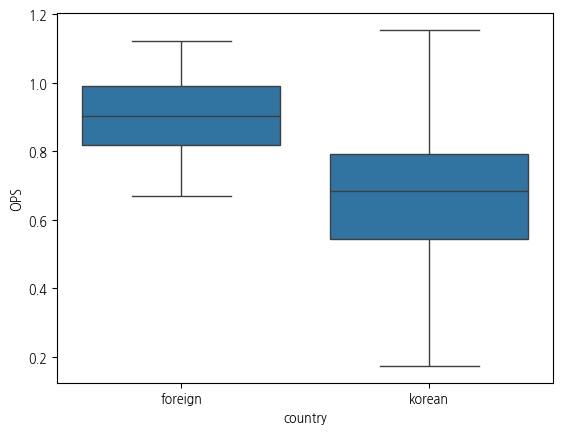

In [128]:
cnt_country = regular_season_df.groupby('country')['OPS'].count()
mean_country = regular_season_df.groupby('country')['OPS'].mean()
med_country = regular_season_df.groupby('country')['OPS'].median()
print('N= ', cnt_country)
print('평균= ', mean_country)
print('중앙값= ', med_country)

sns.boxplot(data=regular_season_df, x='country', y='OPS', showfliers=False)  # showfliers=False 옵션은 극단값을 제외한다. 

- 한국/외국인 선수의 OPS가 유의미한 차이 존재하는 듯 (단 외국인 선수 숫자가 적어 유의 필요)

In [116]:
# 초봉(starting_salary)과 OPS 
## 외국인 선수 연봉은 달러로 표시되나, 선수숫자가 적으므로 무시(결측치 처리함)

regular_season_df['starting_salary'] = regular_season_df['starting_salary'].apply(lambda x: x if pd.isnull(x) 
                                                                                             else (int(re.findall('\d+', x)[0]) if '만원' in x else np.nan))
regular_season_df['starting_salary'].value_counts()

starting_salary
10000.0    177
6000.0     117
3000.0     105
9000.0      97
5000.0      91
8000.0      89
30000.0     74
4000.0      62
12000.0     62
18000.0     54
7000.0      53
11000.0     49
13000.0     48
20000.0     46
25000.0     45
15000.0     41
16000.0     28
14000.0     26
28000.0     20
43000.0     17
45000.0     16
27000.0     15
21000.0     13
23000.0     12
33000.0     10
6500.0      10
17000.0      1
Name: count, dtype: int64

평균초봉(만원)=  12622.64
corr(초봉&OPS)= 0.18085021222259404


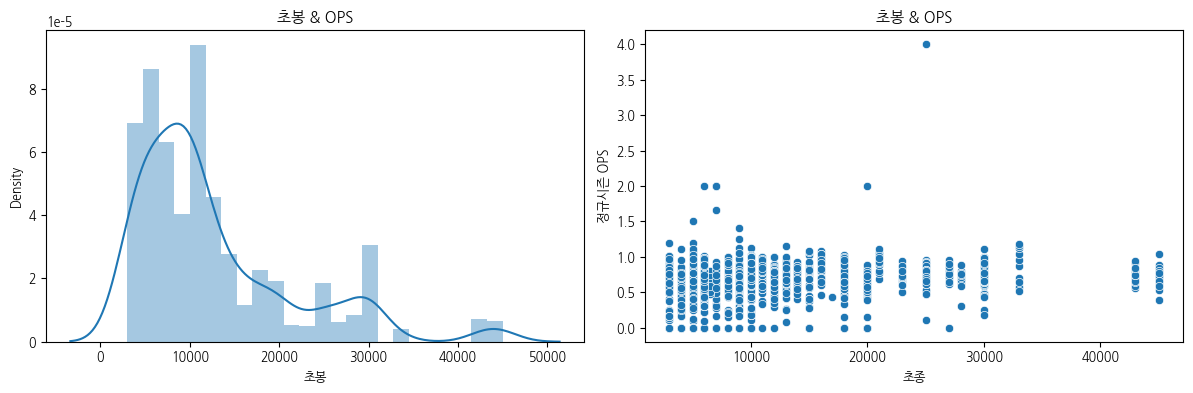

In [123]:
print('평균초봉(만원)= ', round(regular_season_df['starting_salary'].mean(),2))
print('corr(초봉&OPS)=', regular_season_df['starting_salary'].corr(regular_season_df['OPS']))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.distplot(regular_season_df['starting_salary'], kde=True, ax=axes[0])
axes[0].set_title('초봉 & OPS')
axes[0].set_xlabel('초봉')
axes[0].set_ylabel('Density')

sns.scatterplot(data=regular_season_df, x='starting_salary', y='OPS', ax=axes[1])
axes[1].set_title('초봉 & OPS')
axes[1].set_xlabel('초종')
axes[1].set_ylabel('정규시즌 OPS')

plt.tight_layout()
plt.show()

- 첫 연봉과 OPS간에도 별다른 관계성이 보이지 않음 

---
##### 데일리 데이터 확인 
- Pre_Season_Batter, Regular_Season_Batter는 기간내 평균인데 반해, Regular_Season_Batter_Day_by_Day_b4는 일자별 데이터임 

In [124]:
day_by_day = pd.read_csv('KBO_data\Regular_Season_Batter_Day_by_Day_b4.csv')
display(day_by_day.shape, day_by_day.head())

(112273, 20)

,batter_id,batter_name,date,opposing_team,avg1,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,HBP,SO,GDP,avg2,year
0,0,가르시아,3.24,NC,0.333,3,1,1,0,0,0,0,0,0,1,0,1,0,0.333,2018
1,0,가르시아,3.25,NC,0.000,4,0,0,0,0,0,0,0,0,0,0,1,0,0.143,2018
2,0,가르시아,3.27,넥센,0.200,5,0,1,0,0,0,0,0,0,0,0,0,0,0.167,2018
3,0,가르시아,3.28,넥센,0.200,5,1,1,0,0,0,1,0,0,0,0,0,0,0.176,2018
4,0,가르시아,3.29,넥센,0.250,4,0,1,0,0,0,3,0,0,0,0,0,1,0.190,2018
